In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
def angle3d(x1,y1,z1,x2,y2,z2,x3,y3,z3, smearing, cry_side=1.53, fwhm_doi=3 ):
    if smearing == True:
        #doi smearing
        x1 = np.random.normal(x1, 3/2.355)
        x2 = np.random.normal(x1, 3/2.355)
        x3 = np.random.normal(x1, 3/2.355)
        
        #crystals smearing #TODO: crystal centers
        y1 = np.random.uniform(y1-cry_side/2, y1+cry_side/2)
        y2 = np.random.uniform(y2-cry_side/2, y2+cry_side/2)
        y3 = np.random.uniform(y3-cry_side/2, y3+cry_side/2)
        z1 = np.random.uniform(z1-cry_side/2, z1+cry_side/2)
        z2 = np.random.uniform(z2-cry_side/2, z2+cry_side/2)
        z3 = np.random.uniform(z3-cry_side/2, z3+cry_side/2)
        
    a = np.array([x1,y1,z1])
    b = np.array([x2,y2,z2])
    c = np.array([x3,y3,z3])
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.pi - np.arccos(cosine_angle)
    return (angle)


def errorangle3d(angle, energy2, fwhm_en_perc):
    energyerr = fwhm_en_perc*energy2/2.355
    return abs(0.511*energyerr/(np.sin(angle)*((0.511-energy2)**2)))

def select_columns(data_frame, column_names):
    new_frame = data_frame.loc[:, column_names]
    return new_frame



def build_model():
    model = keras.Sequential([layers.Dense(5, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(5, activation=tf.nn.relu),
    layers.Dense(2, activation=tf.nn.softmax)])

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],
           label='Acc')
    plt.legend()
    plt.show()
    

In [19]:
#dataset_path = '/home/pipsini/Documents/CERN/PET/programs/PET-Coincidences-Compton/macro/build/test_compton_big.txt'
#dataset_path = '/home/pipsini/Documents/CERN/PET/programs/PET-Coincidences-Compton/macro/build/test_compton_small.txt'
dataset_path = '/home/pipsini/Documents/CERN/PET/programs/PET-Coincidences-Compton/macro/build/test_compton.txt'

raw_dataset = pd.read_csv(dataset_path, sep="\t", usecols=range(0,18))
dataset = raw_dataset.copy()

angle = []
anglewrong = []
angle_smeared = []
anglewrong_smeared = []
en2_smeared = []
en3_smeared = []

fwhm_doi = 3
fwhm_en_perc = 0.1
cry_side = 1.53


for index, row in dataset.iterrows():
    #angle with no smearing
    angle.append(angle3d(row['x1'],row['y1'],row['z1'],row['x2'],row['y2'],row['z2'],row['x3'],row['y3'],row['z3'], smearing=False))          
    anglewrong.append(angle3d(row['x1'],row['y1'],row['z1'],row['x3'],row['y3'],row['z3'],row['x2'],row['y2'],row['z2'], smearing=False))  
    
    #angle with smearing
    anglevalue = angle3d(row['x1'],row['y1'],row['z1'],row['x2'],row['y2'],row['z2'],row['x3'],row['y3'],row['z3'], smearing=True)
    anglewrongvalue = angle3d(row['x1'],row['y1'],row['z1'],row['x3'],row['y3'],row['z3'],row['x2'],row['y2'],row['z2'], smearing=True)
    angle_smeared.append(np.random.normal(anglevalue,errorangle3d(anglevalue, row['energy2'], fwhm_en_perc)))            
    anglewrong_smeared.append(np.random.normal(anglewrongvalue,errorangle3d(anglewrongvalue, row['energy3'], fwhm_en_perc)))            
        
    #energy with smearing 
    en2_smeared.append(np.random.normal(row['energy2'], fwhm_en_perc*row['energy2']/2.355))
    en3_smeared.append(np.random.normal(row['energy3'], fwhm_en_perc*row['energy3']/2.355))


#fill the dataframe
dataset['compt_angle'] = angle
dataset['compt_angle_wrong'] = anglewrong
dataset['compt_angle_smeared'] = angle_smeared
dataset['compt_angle_wrong_smeared'] = anglewrong_smeared
dataset['energy2_smeared'] = en2_smeared
dataset['energy3_smeared'] = en3_smeared

#remove not a number angles (same position of compton) #how is this possible??
dataset = dataset.dropna()
#dataset.head()

/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [20]:
smearing = True


if smearing == False:
    variables = ['energy2', 'energy3','compt_angle','compt_angle_wrong']
else:
    variables = ['energy2_smeared', 'energy3_smeared','compt_angle_smeared','compt_angle_wrong_smeared']    

    
dataset_preparing = select_columns(dataset, variables)
dataset_corr = select_columns(dataset_preparing, [variables[0], variables[1], variables[2]])
dataset_incorr = select_columns(dataset_preparing, [variables[0], variables[1], variables[3]])

dataset_incorr.columns = ['energy2', 'energy3','compt_angle']
dataset_corr.columns = ['energy2', 'energy3','compt_angle']


dataset_corr['label'] = [1]*len(dataset_corr)
dataset_incorr['label'] = [0]*len(dataset_incorr)


MLdataset = dataset_corr.append(dataset_incorr)
print(len(MLdataset))
MLdataset.head()

249544


,energy2,energy3,compt_angle,label
0,0.234583,0.265623,1.235321,1
1,0.233424,0.261998,1.255565,1
2,0.185185,0.330955,0.595910,1
3,0.122796,0.405141,0.665730,1
4,0.314857,0.197597,2.383119,1


In [21]:
#split train and test
MLdataset = shuffle(MLdataset)

train_dataset = MLdataset.sample(frac=0.8,random_state=0)
test_dataset = MLdataset.drop(train_dataset.index)

train_labels = train_dataset.pop('label')
test_labels = test_dataset.pop('label')



In [6]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 12        
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________


In [7]:
EPOCHS=20

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(train_dataset, train_labels, epochs=EPOCHS, callbacks=[early_stop])


Epoch 1/20
199635/199635 [==============================] - 13s 65us/sample - loss: 0.5527 - acc: 0.7323
Epoch 2/20
199635/199635 [==============================] - 13s 64us/sample - loss: 0.4403 - acc: 0.7939
Epoch 3/20
199635/199635 [==============================] - 13s 64us/sample - loss: 0.4310 - acc: 0.7991
Epoch 4/20
199635/199635 [==============================] - 13s 64us/sample - loss: 0.4277 - acc: 0.8006
Epoch 5/20
199635/199635 [==============================] - 13s 64us/sample - loss: 0.4255 - acc: 0.8017
Epoch 6/20
199635/199635 [==============================] - 13s 65us/sample - loss: 0.4241 - acc: 0.8021
Epoch 7/20
199635/199635 [==============================] - 13s 64us/sample - loss: 0.4228 - acc: 0.8033
Epoch 8/20
199635/199635 [==============================] - 13s 63us/sample - loss: 0.4218 - acc: 0.8033
Epoch 9/20
199635/199635 [==============================] - 13s 65us/sample - loss: 0.4210 - acc: 0.8034
Epoch 10/20
199635/199635 [============================

In [22]:
#Let's see how well the model generalizes by using the test set, which we 
#did not use when training the model. This tells us how well we can expect the 
#model to predict when we use it in the real world.
test_loss, test_acc = model.evaluate(test_dataset, test_labels)
print('Test accuracy:', test_acc)


159558/159558 [==============================] - 5s 29us/sample - loss: 0.4152 - acc: 0.8073
Test accuracy: 0.8072989


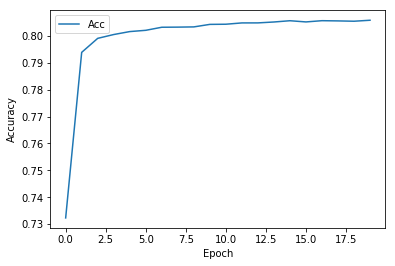

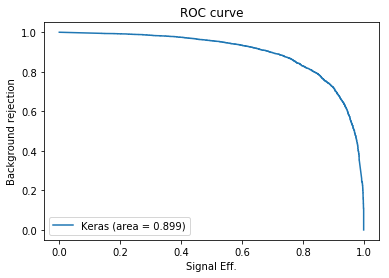

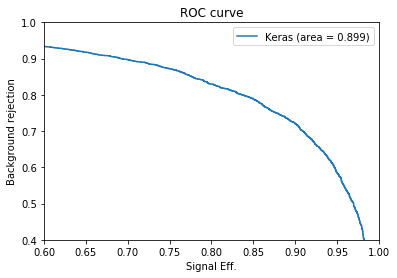

In [9]:
#plot accuracy history
plot_history(history)

# Plot ROC curve
y_pred_keras = model.predict(test_dataset)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras[:,1])
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
#plt.plot([0, 1], [0, 1], 'k--')
plt.plot(tpr_keras, 1-fpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('Signal Eff.')
plt.ylabel('Background rejection')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
#plt.plot([0.6, 1], [0.95, 1], 'k--')
plt.plot(tpr_keras, 1-fpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('Signal Eff.')
plt.ylabel('Background rejection')
plt.xlim(0.6, 1)
plt.ylim(0.4, 1)
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()